# Task 2 - Uploading Dataset to GCP and Processing the data

## Sebastian Steen
Group Number 9 - Naive Baes

Question from Previous Assignment:
I am curious about exploring the average ratings and helpfulness per userid
across some product categories and individual ones. I wonder if we can classify
these reviews and use word frequency (to borrow from Patrick) to see if we can
create a bot that can generate either positive or negative reviews based on the
helpfulness of those reviews. I also wonder if we can rescale ratings by reviewer
to recalculate the average reviews so that users who always give positive
reviews (lets say 3-5) and those who generally give negative reviews (1-3) are
rescaled to 1-5. This may provide us with a more accurate rating and if bots are
purpose made for negative or positive reviews, it can blunt their effects on total
ratings.

What I am finding out: 
Average rating, average helpfulness votes, and total reviews by userID. I also added average wordcount per helpfulness review. I borrowed the idea from Patrick and ratings, I was curious about whether high and low helpfulness follows a different pattern than high and low ratings.

In [1]:
import pandas as pd
import pyspark
import os
import types
import datetime
import json

In [2]:
video_games = pd.read_json("/Users/sebastiansteen/Desktop/MSDS/DistributedComputing/Group Project/Video_Games.jsonl", lines = True)

In [3]:
software = pd.read_json("/Users/sebastiansteen/Desktop/MSDS/DistributedComputing/Group Project/Software.jsonl", lines = True)

In [4]:
df_vg = video_games.drop(video_games.columns[3], axis=1)
df_vg["category"] = "video_games"
df_vg.head(5)

,rating,title,text,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,category
0,4,It’s pretty sexual. Not my fav,I’m playing on ps5 and it’s interesting. It’s...,B07DJWBYKP,B07DK1H3H5,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,2020-12-17 06:33:24.795,0,True,video_games
1,5,Good. A bit slow,Nostalgic fun. A bit slow. I hope they don’t...,B00ZS80PC2,B07SRWRH5D,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,2020-04-16 15:31:54.941,1,False,video_games
2,5,... an order for my kids & they have really en...,This was an order for my kids & they have real...,B01FEHJYUU,B07MFMFW34,AGXVBIUFLFGMVLATYXHJYL4A5Q7Q,2017-03-30 12:37:11.000,0,True,video_games
3,5,Great alt to pro controller,"These work great, They use batteries which is ...",B07GXJHRVK,B0BCHWZX95,AFTC6ZR5IKNRDG5JCPVNVMU3XV2Q,2019-12-29 16:40:34.017,0,True,video_games
4,5,solid product,I would recommend to anyone looking to add jus...,B00HUWA45W,B00HUWA45W,AFTC6ZR5IKNRDG5JCPVNVMU3XV2Q,2015-03-29 01:18:52.000,0,True,video_games


In [5]:
df_soft = software.drop(software.columns[3], axis=1)
df_soft["category"] = "software"
software.head(5)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,1,malware,mcaffee IS malware,[],B07BFS3G7P,B0BQSK9QCF,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,2019-07-03 19:37:12.076,0,False
1,5,Lots of Fun,I love playing tapped out because it is fun to...,[],B00CTQ6SIG,B00CTQ6SIG,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2015-02-16 20:58:56.000,0,True
2,5,Light Up The Dark,I love this flashlight app! It really illumin...,[],B0066WJLU6,B0066WJLU6,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2013-03-04 12:14:27.000,0,True
3,4,Fun game,One of my favorite games,[],B00KCYMAWK,B00KCYMAWK,AH6CATODIVPVUOJEWHRSRCSKAOHA,2019-06-20 20:10:28.662,0,True
4,4,I am not that good at it but my kids are,Cute game. I am not that good at it but my kid...,[],B00P1RK566,B00P1RK566,AEINY4XOINMMJCK5GZ3M6MMHBN6A,2014-12-11 00:19:56.000,0,True


In [6]:
import json

def createRDD(sc, filename, field_order, types):
    raw_rdd = sc.textFile(filename)

    # ... (Keep parse_json_line and has_value and casters functions the same) ...
    # Note: Use from datetime import datetime for your casters to work

    def parse_json_line(line):
        try:
            return json.loads(line)
        except json.JSONDecodeError as e:
            # In a real Spark job, you might want to log this better than print()
            return None 

    def has_value(x):
        return x is not None and x != ""

    casters = {
        "int": lambda x: int(x) if has_value(x) else None,
        "float": lambda x: float(x) if has_value(x) else None,
        "str": lambda x: x if x is not None else "",
        "bool": lambda x:x if isinstance(x, bool) else (x.lower() in ("1", "true", "t", "yes", "y")) if has_value(x) else None,
        "date": lambda x: datetime.datetime.fromtimestamp(x/1000.0).date() if x else None
    }

    def cast_row_to_dict(record):
        casted_dict = {}
        for i, name in enumerate(field_order):
            value = record.get(name)
            target_type = types[i]
            casted_dict[name] = casters[target_type](value)
        return casted_dict
    # --- End modification ---

    return (raw_rdd
            .map(parse_json_line)
            .filter(lambda x: x is not None)
            .map(cast_row_to_dict)) # Use the new function


In [7]:

sc = pyspark.SparkContext(appName="software_ratings").getOrCreate()


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/01 18:25:16 WARN Utils: Your hostname, Sebastians-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 192.168.12.23 instead (on interface en0)
25/12/01 18:25:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/01 18:25:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [8]:
fields = ["rating", "title", "text", "images", "asin", "parent_asin", "user_id", "timestamp", "helpful_vote", "verified_purchase"]
types = ["int","str","str","str","str","str","str","date","int","bool"]
soft_rdd_unclean = createRDD(sc, "/Users/sebastiansteen/Desktop/MSDS/DistributedComputing/Group Project/Software.jsonl", fields, types)

In [9]:
first_record = soft_rdd_unclean.first()
first_tuple = soft_rdd_unclean.first()
first_tuple

{'rating': 1,
 'title': 'malware',
 'text': 'mcaffee IS malware',
 'images': [],
 'asin': 'B07BFS3G7P',
 'parent_asin': 'B0BQSK9QCF',
 'user_id': 'AGCI7FAH4GL5FI65HYLKWTMFZ2CQ',
 'timestamp': datetime.date(2019, 7, 3),
 'helpful_vote': 0,
 'verified_purchase': False}

In [10]:
fields = ["rating", "title", "text", "images", "asin", "parent_asin", "user_id", "timestamp", "helpful_vote", "verified_purchase"]
types = ["int","str","str","str","str","str","str","date","int","bool"]
vg_rdd_unclean = createRDD(sc, "/Users/sebastiansteen/Desktop/MSDS/DistributedComputing/Group Project/Video_Games.jsonl", fields, types)

In [11]:
soft_rdd = soft_rdd_unclean.map(lambda row_dict: {k: v for k, v in row_dict.items() if k != 'images'}).map(lambda row_dict: {**row_dict, "category": "software"})
vg_rdd = vg_rdd_unclean.map(lambda row_dict: {k: v for k, v in row_dict.items() if k != 'images'}).map(lambda row_dict: {**row_dict, "category": "software"})

In [12]:
def ratings_helpfulness_per_userid(rdd):
    user_pairs_rdd = rdd.map(lambda x: (x['user_id'], (x['rating'], x['helpful_vote']))
                             )
    createCombiner = lambda value: (value[0], value[1], 1)
    mergeValue = lambda acc, val: (acc[0] + val[0], acc[1] + val[1], acc[2] + 1)
    mergeCombiners = lambda acc1, acc2: (acc1[0] + acc2[0], acc1[1] + acc2[1], acc1[2] + acc2[2])
    combined_totals_rdd = user_pairs_rdd.combineByKey(
        createCombiner,
        mergeValue,
        mergeCombiners
    )
    averages_rdd = combined_totals_rdd.map(lambda kv: 
        {
            "user_id": kv[0],
            "avg_rating": round(kv[1][0] / kv[1][2], 2), # sum_rating / count
            "avg_helpfulness": round(kv[1][1] / kv[1][2], 2), # sum_helpfulness / count
            "review_count": kv[1][2]
        }
    )
    rdd_to_sort = averages_rdd.map(
    lambda record_dict: (record_dict['avg_helpfulness'], record_dict))
    sorted_pair_rdd = rdd_to_sort.sortByKey(ascending=False)
    sorted_results_rdd = sorted_pair_rdd.map(lambda key_value_pair: key_value_pair[1])
    return sorted_results_rdd

In [13]:
sample_rdd = soft_rdd.sample(withReplacement=False, fraction=0.01, seed=42)

In [14]:
avg_per_user = ratings_helpfulness_per_userid(sample_rdd)

In [15]:
avg_per_user

PythonRDD[16] at RDD at PythonRDD.scala:56

In [16]:
sample2_rdd = vg_rdd.sample(withReplacement=False, fraction=0.01, seed=42)
helpfulness_pairs = sample2_rdd.map(
    lambda x: (int(x['helpful_vote']), (len(x['text']), 1))
)

# Sum lengths and counts per helpfulness level
summed_by_helpfulness = helpfulness_pairs.reduceByKey(
    lambda a, b: (a[0] + b[0], a[1] + b[1])
)

# Turn (total_length, count) → average length, rounded
avg_length_by_helpfulness_rdd = summed_by_helpfulness.mapValues(
    lambda s: round(s[0] / s[1], 2)
)

# Get a Python dict: {helpful_vote: avg_review_length}
average_review_length_by_helpfulness = avg_length_by_helpfulness_rdd.collectAsMap()

In [17]:
average_review_length_by_helpfulness

{0: 196.09,
 1: 404.03,
 81: 816.0,
 2: 613.33,
 3: 727.35,
 4: 865.36,
 244: 8871.0,
 84: 1675.0,
 5: 933.06,
 85: 2241.0,
 6: 1082.24,
 86: 12332.0,
 7: 1030.22,
 87: 1130.0,
 407: 1487.0,
 8: 1144.91,
 88: 4504.33,
 9: 1213.26,
 10: 1193.47,
 11: 1033.33,
 91: 4079.67,
 12: 977.88,
 332: 140.0,
 92: 12761.0,
 13: 1179.06,
 173: 180.0,
 93: 1347.0,
 14: 1705.23,
 174: 8737.0,
 15: 1215.53,
 16: 1071.34,
 17: 1102.03,
 97: 7818.0,
 18: 1594.96,
 98: 457.0,
 19: 1274.71,
 99: 1306.0,
 20: 1686.65,
 420: 708.0,
 21: 830.26,
 101: 1240.0,
 181: 848.0,
 22: 1111.88,
 182: 2089.0,
 23: 1523.0,
 103: 599.5,
 24: 1847.79,
 25: 2572.08,
 26: 2462.73,
 266: 1162.0,
 27: 1819.17,
 187: 10790.0,
 107: 1909.0,
 28: 2068.0,
 108: 4514.0,
 29: 2157.0,
 30: 1201.12,
 31: 1437.83,
 351: 2947.0,
 111: 887.0,
 32: 1447.6,
 112: 315.0,
 33: 2260.0,
 113: 1592.0,
 34: 1869.43,
 35: 2167.71,
 115: 2178.0,
 36: 1598.67,
 37: 2109.0,
 38: 353.4,
 39: 1024.14,
 200: 749.0,
 40: 1541.33,
 41: 1368.57,
 42: 74

In [18]:
sort = sorted(average_review_length_by_helpfulness.items(), key=lambda item: -item[0])
sort

[(1980, 9020.0),
 (420, 708.0),
 (407, 1487.0),
 (396, 106.0),
 (377, 7177.0),
 (362, 2721.0),
 (351, 2947.0),
 (332, 140.0),
 (309, 1865.0),
 (292, 3234.0),
 (291, 9538.0),
 (266, 1162.0),
 (244, 8871.0),
 (238, 3037.0),
 (235, 1162.0),
 (225, 2386.0),
 (223, 1221.0),
 (219, 5340.0),
 (203, 4516.0),
 (200, 749.0),
 (187, 10790.0),
 (182, 2089.0),
 (181, 848.0),
 (174, 8737.0),
 (173, 180.0),
 (152, 6489.0),
 (146, 2539.5),
 (135, 1625.0),
 (124, 503.0),
 (123, 3143.0),
 (115, 2178.0),
 (113, 1592.0),
 (112, 315.0),
 (111, 887.0),
 (108, 4514.0),
 (107, 1909.0),
 (103, 599.5),
 (101, 1240.0),
 (99, 1306.0),
 (98, 457.0),
 (97, 7818.0),
 (93, 1347.0),
 (92, 12761.0),
 (91, 4079.67),
 (88, 4504.33),
 (87, 1130.0),
 (86, 12332.0),
 (85, 2241.0),
 (84, 1675.0),
 (81, 816.0),
 (79, 359.0),
 (78, 4759.0),
 (77, 1582.0),
 (74, 1268.25),
 (73, 1432.33),
 (72, 3184.0),
 (71, 3774.67),
 (68, 2499.0),
 (67, 1002.0),
 (66, 257.5),
 (65, 1023.0),
 (64, 2994.5),
 (62, 1937.5),
 (61, 1160.0),
 (59, 2

In [19]:
df = pd.DataFrame(sort, columns=['Helpfulness_Score', 'Average_Review_Length'])

bins = [0, 20, 40, 60, 80, 10000000]
labels = ['Low','Medium-low', 'Medium', 'Medium-high', 'High']

df['Helpfulness_Bin'] = pd.cut(df['Helpfulness_Score'], bins=bins, labels=labels, right=False)

average_length_per_bin = df.groupby('Helpfulness_Bin')['Average_Review_Length'].mean()

print("Average Review Length Per Bin")
print(average_length_per_bin)

Average Review Length Per Bin
Helpfulness_Bin
Low            1027.869500
Medium-low     1677.373000
Medium         1751.978421
Medium-high    1945.196429
High           3360.640000
Name: Average_Review_Length, dtype: float64


/var/folders/w5/zfp2qr551rz32w05qqxrkw9m0000gn/T/ipykernel_17962/3275990050.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_length_per_bin = df.groupby('Helpfulness_Bin')['Average_Review_Length'].mean()


In [20]:
def avg_rate_by_user(rdd):
    user_pairs_rdd = rdd.map(lambda x: (x['user_id'], (x['rating'], x['helpful_vote']))
                             )
    createCombiner = lambda value: (value[0], value[1], 1)
    mergeValue = lambda acc, val: (acc[0] + val[0], acc[1] + val[1], acc[2] + 1)
    mergeCombiners = lambda acc1, acc2: (acc1[0] + acc2[0], acc1[1] + acc2[1], acc1[2] + acc2[2])
    combined_totals_rdd = user_pairs_rdd.combineByKey(
        createCombiner,
        mergeValue,
        mergeCombiners
    )
    averages_rdd = combined_totals_rdd.map(lambda kv: 
        {
            "user_id": kv[0],
            "avg_rating": round(kv[1][0] / kv[1][2], 2), # sum_rating / count
            "avg_helpfulness": round(kv[1][1] / kv[1][2], 2), # sum_helpfulness / count
            "review_count": kv[1][2]
        }
    )
    rdd_to_sort = averages_rdd.map(
    lambda record_dict: (record_dict['avg_helpfulness'], record_dict))
    sorted_pair_rdd = rdd_to_sort.sortByKey(ascending=False)
    sorted_results_rdd = sorted_pair_rdd.map(lambda key_value_pair: key_value_pair[1])
    return sorted_results_rdd

In [21]:
avg_rating_per_user_rdd = avg_rate_by_user(sample_rdd)

In [ ]:
def calibrated_ratings_per_user(avg_rating_per_user_rdd, ratings_rdd, min_reviews_per_user=5):
    """
    Recalibrate ratings so each user's average rating becomes 3.0.
    Optionally ignore users with fewer than `min_reviews_per_user` reviews.
    """

    # (user_id, (avg_rating, review_count))
    avg_by_user_rdd = avg_rating_per_user_rdd.map(
        lambda d: (d["user_id"], (d["avg_rating"], d["review_count"]))
    )

    # (user_id, review_dict)
    ratings_by_user_rdd = ratings_rdd.map(
        lambda d: (d["user_id"], d)
    )

    # (user_id, (review_dict, (avg_rating, review_count)))
    joined_rdd = ratings_by_user_rdd.join(avg_by_user_rdd)

    # use users with at least N reviews
    filtered_rdd = joined_rdd.filter(
        lambda kv: kv[1][1][1] >= min_reviews_per_user
    )

    def apply_calibration(kv):
        user_id, (review_dict, (avg_rating, review_count)) = kv

        shift = 3.0 - avg_rating
        new_review = review_dict.copy()
        raw_calibrated = new_review["rating"] + shift

        # Keep within [1, 5]
        calibrated = max(1.0, min(5.0, raw_calibrated))
        new_review["calibrated_rating"] = round(calibrated, 2)

        return new_review

    calibrated_rdd = filtered_rdd.map(apply_calibration)
    return calibrated_rdd

In [33]:
calib_rate = calibrated_ratings_per_user(avg_rating_per_user_rdd, sample_rdd, min_reviews_per_user=1)

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder.getOrCreate()

def avg_rating_by_asin(rdd, rating_key):
    # (asin, (sum_rating, count))
    pair_rdd = rdd.map(lambda x: (x['asin'], (x[rating_key], 1)))
    summed_rdd = pair_rdd.reduceByKey(
        lambda a, b: (a[0] + b[0], a[1] + b[1])
    )
    # (asin, (avg_rating, count))
    return summed_rdd.map(lambda kv: (kv[0], (kv[1][0] / kv[1][1], kv[1][1])))

# Original and calibrated averages per product (with counts)
orig_avg_by_asin_rdd = avg_rating_by_asin(sample_rdd, 'rating')
calib_avg_by_asin_rdd = avg_rating_by_asin(calib_rate, 'calibrated_rating')

# Join to get: (asin, ((orig_avg, orig_count), (calib_avg, calib_count)))
joined_rdd = orig_avg_by_asin_rdd.join(calib_avg_by_asin_rdd)

# 🔹 Keep only products with more than one rating (using original count)
filtered_rdd = joined_rdd.filter(lambda kv: kv[1][0][1] > 10)

# Turn into a dict RDD with the difference
diff_rdd = filtered_rdd.map(lambda kv: {
    "asin": kv[0],
    "orig_avg": kv[1][0][0],            # original avg rating
    "calib_avg": kv[1][1][0],           # calibrated avg rating
    "delta": kv[1][1][0] - kv[1][0][0], # change in avg
    "count": kv[1][0][1]                # number of ratings (optional but handy)
})

# Focus on products that changed the most
diff_df = spark.createDataFrame(diff_rdd)
top_df = diff_df.orderBy(F.abs(F.col("delta")).desc()).limit(30)  # top 30 by |delta|
pdf = top_df.toPandas()


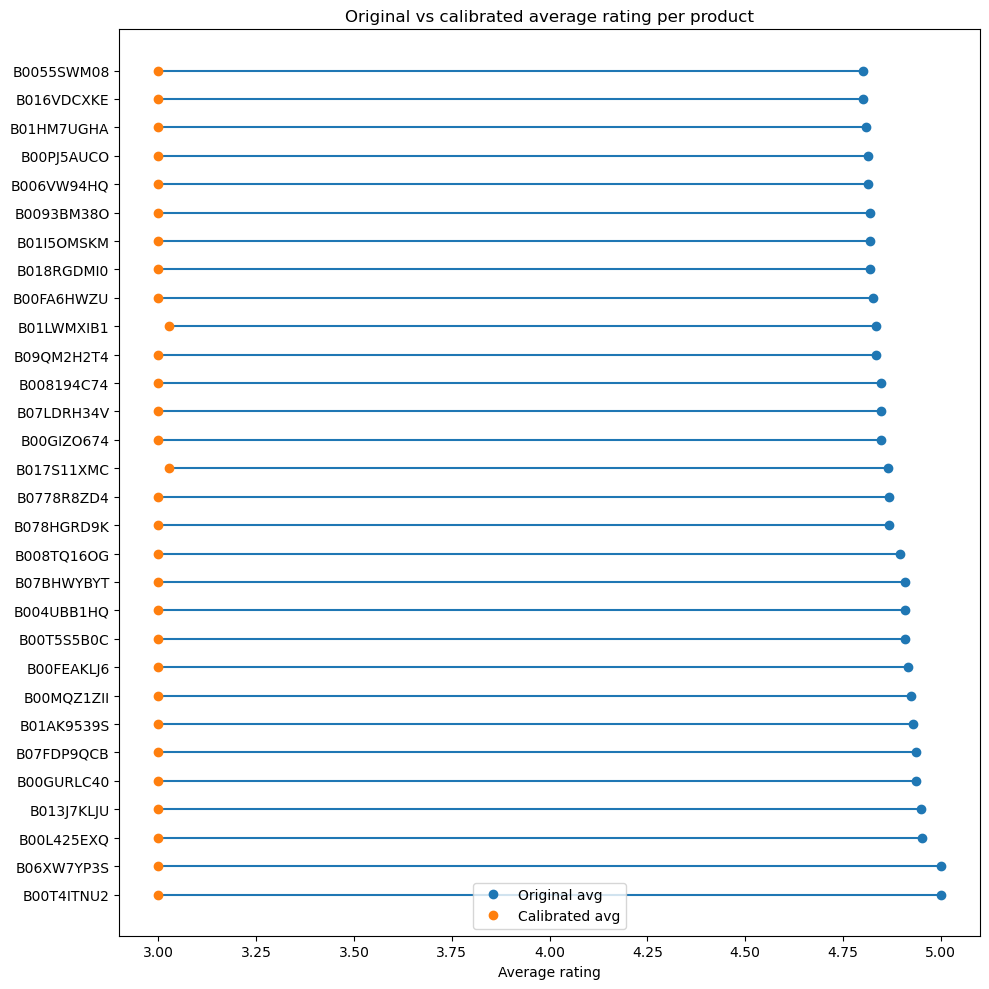

In [35]:
import matplotlib.pyplot as plt

# Sort products for nicer layout (e.g. by original avg)
pdf = pdf.sort_values("orig_avg")
y_positions = range(len(pdf))

plt.figure(figsize=(10, 10))

# Draw the lines between original and calibrated
plt.hlines(
    y=y_positions,
    xmin=pdf["orig_avg"],
    xmax=pdf["calib_avg"]
)

# Original avg points
plt.plot(
    pdf["orig_avg"],
    y_positions,
    'o',
    label="Original avg"
)

# Calibrated avg points
plt.plot(
    pdf["calib_avg"],
    y_positions,
    'o',
    label="Calibrated avg"
)

plt.yticks(y_positions, pdf["asin"])
plt.xlabel("Average rating")
plt.title("Original vs calibrated average rating per product")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [40]:

diff_df = spark.createDataFrame(diff_rdd)  # all   
pdf = diff_df.toPandas()


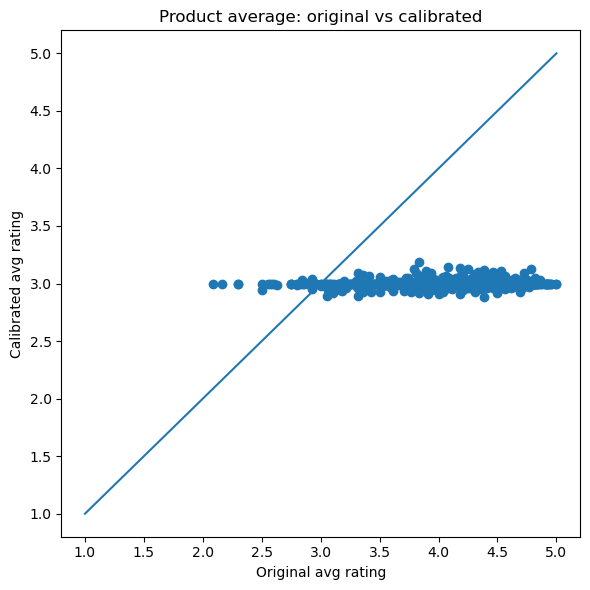

In [37]:
plt.figure(figsize=(6, 6))
plt.scatter(pdf["orig_avg"], pdf["calib_avg"])
plt.plot([1, 5], [1, 5])  # diagonal y = x, assuming 1–5 scale
plt.xlabel("Original avg rating")
plt.ylabel("Calibrated avg rating")
plt.title("Product average: original vs calibrated")
plt.tight_layout()
plt.show()

## I am insanely interested in figuring out why, after normalizing user ratings by user_id, the average ratings of every product clusters closely to 3. If the math behind it is correct, this may indicate that certain products get bought and reviewed by insanely optimistic or pesimistic individuals respectively. Another theory may be that the vast majority of users that review are actually spammers that solely focus on 1 or 5 star reviews. The above graph seems to show a normal distribution (when it comes to the density of points) with greatest variation around the mean... super curious stuff if I had not made a mistake.